tgb - 11/12/2019 - Phase 1 of the project - Changing the inputs without changing the outputs

# 0) Initialization

Import utilities

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W1115 17:06:10.289977 23176969754432 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1115 17:06:10.290616 23176969754432 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1115 17:06:10.292392 23176969754432 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Develop utilities to recast inputs

We would like to rephrase two types of inputs:  
1) Temperature as a deviation from the moist adiabat to avoid going out of training  
2) Moisture variables, including microphysical variables, as relative humidities to avoid going out of training  
3) Fow now, we will ignore "large-scale tendencies"   
We will then train networks with similar architectures, one with "rephrased" inputs and one without to see if the one with "rephrased" inputs generalizes better to +4K near the Equator

In [2]:
data = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)

In [3]:
data

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 ... 0.9375 0.9583 0.9792
Dimensio

## 1.1) Code up relative humidity from Tristan's utilities

From [https://github.com/thabbott/matlab]. Since the microphysics scheme is one-moment, we only need to keep track of a single relative humidity that takes into account both the saturation pressure with respect to liquid and ice.

In [4]:
# SAM Constants, TODO = Check that they are the same in SPCAM
# In functions
a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
c_liq = -80
c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
# General
cp = 1.004e3
g = 9.81
Lc = 2.5104e6
Lf = 0.3336e6
Ls = 2.8440e6
R = 287
Rv = 461
T0 = 273.16
T0p = 283.16
T00 = 253.16
T00p = 268.16

In [5]:
# Test variables
T = data.T # Absolute temperature (K)
# From temperature, get saturation pressure over liquid
Xliq = np.maximum(c_liq,T-T0)
eliq = 100*np.polyval(a_liq,Xliq)

In [6]:
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [7]:
def deliqdT(T):
    a_liq = np.array([-0.599634321e-17,-0.792933209e-14,-0.604119582e-12,0.385208005e-9,0.103167413e-6,0.121167162e-4,0.794747212e-3,0.285976452e-1,0.443956472])
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [8]:
# Test variables
T = data.T.values # Absolute temperature (K)
# From temperature, set saturation pressure over ice
eice = (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

In [9]:
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [10]:
def deicedT(T):
    a_ice = np.array([0.497275778e-16,0.390204672e-13,0.132073448e-10,0.255653718e-8,0.312668753e-6,0.249065913e-4,0.126710138e-2,0.377174432e-1,0.503223089])
    c_ice = np.array([273.15,185,-100,0.0013186,2.60269e-05,1.28676e-07])
    T0 = 273.16
    return (T>c_ice[0])*deliqdT(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [11]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

In [12]:
# Test variables
p = np.moveaxis((data.hyam*data.P0+data.hybm*data.PS).values,0,1) # Total pressure (Pa)
T = data.T # Absolute temperature (K)
qv = data.QAP # Specific humidity (kg/kg)
ql = data.QCAP # Liquid water (kg/kg)
qi = data.QIAP # Ice (kg/kg)
# From specific humidity, liquid water and ice to relative humidity
# 1) Partial pressure from total water and temperature
e = Rv*p*qv/R
# 2) Relative humidity from saturation pressure
RH = e/esat(T)
# 3) Relative humidity from saturation specific humidity
qsatl=R/Rv*eliq(T)/np.maximum(eliq(T),p-eliq(T))
RHliq = qv/qsatl
qsati=R/Rv*eice(T)/np.maximum(eice(T),p-eice(T))
RHice = qv/qsati

In [13]:
def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = np.moveaxis((hyam*P0+hybm*PS).values,0,1) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))

In [14]:
RH0 = RH(data.T,data.QAP,data.P0,data.PS,data.hyam,data.hybm)

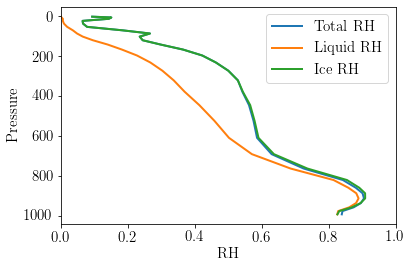

In [15]:
# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

plt.plot(np.mean(RH0,axis=(0,2,3)),data.lev,label='Total RH')
plt.plot(np.mean(RHliq,axis=(0,2,3)),data.lev,label='Liquid RH')
plt.plot(np.mean(RHice,axis=(0,2,3)),data.lev,label='Ice RH')
plt.xlim((0,1))
plt.ylabel('Pressure')
plt.xlabel('RH')
plt.gca().invert_yaxis()
plt.legend()

Text(0.5, 0.98, 'Histogram of Relative humidity')

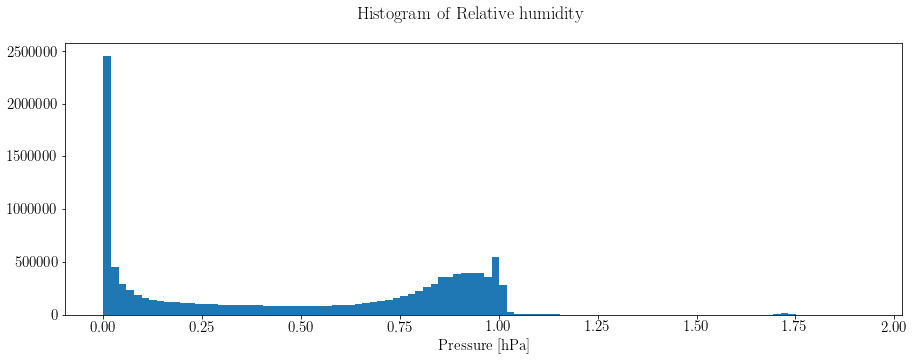

In [16]:
plt.figure(figsize=(15,5))
plt.hist(RH0.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Relative humidity")

Text(0.5, 0.98, 'Histogram of Pressure for which RH larger than1.05')

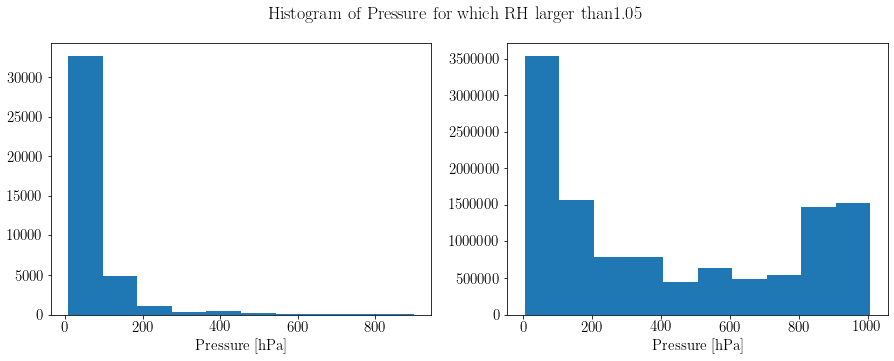

In [17]:
RHthres = 1.05
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(p[RH0>RHthres]/1e2)
plt.xlabel('Pressure [hPa]')
plt.subplot(1,2,2)
plt.hist(p.flatten()/1e2)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Pressure for which RH larger than"+str(RHthres))

## 1.2) Code up deviation from moist adiabatic profile from Tristan's utilities

In [18]:
# Calculate z from hydrostasy and ideal gas law
eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)

r = qv/(qv**0-qv)
Tv = T*(r**0+r/eps)/(r**0+r)
RHO = p/(R*Tv)

Z = -sin.cumtrapz(x=p,y=1/(g*RHO),axis=1)
Z = np.concatenate((np.zeros((p.shape[0],1,p.shape[2],p.shape[3])),Z),axis=1)
Z = Z-Z[:,[-1],:,:]

In [19]:
def geopotential_height(p,qv,T):
    # Calculate z from hydrostasy and ideal gas law
    R = 287
    Rv = 461
    eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)

    r = qv/(qv**0-qv)
    Tv = T*(r**0+r/eps)/(r**0+r)
    RHO = p/(R*Tv)

    if np.size(p.shape)==4:
        Z = -sin.cumtrapz(x=p,y=1/(g*RHO),axis=1)
        Z = np.concatenate((np.zeros((p.shape[0],1,p.shape[2],p.shape[3])),Z),axis=1)
        Z = Z-Z[:,[-1],:,:]
    elif np.size(p.shape)==1:
        Z = -sin.cumtrapz(x=p,y=1/(g*RHO),axis=0)
        Z = np.concatenate((np.zeros(1,),Z),axis=0)
        Z = Z-Z[-1]
    
    return Z

Translating Tristan's script [https://github.com/thabbott/matlab/blob/master/SAMtools/SOM_getState.m] to Python

In [20]:
def qsatliq(T,p):
    R = 287
    Rv = 461
    eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)
    
    e = eliq(T)
    
    return eps*e/np.maximum(e,p-e)

In [21]:
def qsatice(T,p):
    R = 287
    Rv = 461
    eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)
    
    e = eice(T)
    
    return eps*e/np.maximum(e,p-e)

In [22]:
def qsat(T,p):
    R = 287
    Rv = 461
    eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)
    
    e = esat(T)
    
    return eps*e/np.maximum(e,p-e)

In [23]:
def dqsatliqdT(T,p):
    R = 287
    Rv = 461
    eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)
    
    return eps*deliqdT(T)/p

In [24]:
def dqsaticedT(T,p):
    R = 287
    Rv = 461
    eps = R/Rv # Ratio of molecular weight(H2O)/molecular weight(dry air)
    
    return eps*deicedT(T)/p

In [26]:
# Initial conditions: Lowest-level h_l(qp=0), qt, qp=0 and profiles of z and p
omega = np.maximum(0,np.minimum(1,(T[:,-1,:,:]-T00)/(T0-T00))) # Partition function between liquid and ice
z_lift = geopotential_height(p,qv,T) # Geopotential height profile (x,y,p)
qt = qv[:,-1,:,:]+ql[:,-1,:,:]+qi[:,-1,:,:] # Total water assuming qp=0
hL = cp*T[:,-1,:,:]+g*z_lift[:,-1,:,:]-Lc*omega*qt-Ls*(1-omega)*qt # Assumes qp=0
# Changes shape of qt and hL assuming they are conserved throughout the profile
qtad = np.moveaxis(np.tile(np.expand_dims(qt,axis=3),30),3,1)
hLad = np.moveaxis(np.tile(np.expand_dims(hL,axis=3),30),3,1)

In [26]:
# Pre-compute some frequently-used values (qp=0)
an = 1/(T0-T00)
bn = T00*an
ap = 1/(T0p-T00p)
bp = T00p*ap
fac_cond = Lc/cp
fac_sub = Ls/cp
fac_fus = Lf/cp
fac1 = fac_cond+(1+bp)*fac_fus
fac2 = fac_fus*ap

# Pre-allocate arrays
qsatt = np.zeros((np.shape(hLad)))
qn = np.zeros((np.shape(hLad)))

# Make sure that total water concentration is positive
qt = np.maximum(0,qt)

# Calculate initial guess for temperature
Tad = (hLad-g*z_lift)/cp
T1 = Tad
# Calculate qsatt for all cloud types
om = an*T-bn
qsatt = (Tad>T0)*qsatliq(T,p)+(Tad<T00)*qsatice(T,p)+\
(Tad<=T0)*(Tad>=T00)*(om*qsatliq(T,p)+(1-om)*qsatice(T,p))

# Test if condensation possible. Iterate if it is
m0 = (qtad>qsatt)
Tt = Tad[m0]
T1t = T1[m0]
pt = p[m0]
qTt = qtad[m0]
qst = qsatt.values[m0]
dqst = np.zeros((np.shape(qTt)))
lstn = np.zeros((np.shape(qTt)))
dlstn = np.zeros((np.shape(qTt)))
lstp = np.zeros((np.shape(qTt)))
dlstp = np.zeros((np.shape(qTt)))

niter = 0
maxiter = 1
dtabs = 100*np.ones((np.shape(qTt)))

# Debugging
qnd = np.zeros((2*maxiter+1,1))
Td = np.zeros((2*maxiter+1,1))

while ((dtabs>0.01).any()) and niter<maxiter:
    print(niter)
    # Handle cloud condensate
    om = an*T1t-bn
    lstn = (T1t>T0)*fac_cond+(T1t<T00)*fac_sub+\
    (T1t<=T0)*(T1t>=T00)*(fac_cond+(1-om)*fac_fus)
    dlstn = (T1t<=T0)*(T1t>=T00)*fac_fus
    qst = (T1t>T0)*qsatliq(T1t,pt)+(T1t<T00)*qsatice(T1t,pt)+\
    (T1t<=T0)*(T1t>=T00)*(om*qsatliq(T1t,pt)+(1-om)*qsatice(T1t,pt))
    dqst = (T1t>T0)*dqsatliqdT(T1t,pt)+(T1t<T00)*dqsaticedT(T1t,pt)+\
    (T1t<=T0)*(T1t>=T00)*(om*dqsatliqdT(T1t,pt)+(1-om)*dqsaticedT(T1t,pt))
    # Handle precipitable condensate (commented because qp=0)
#     omp = ap*T1t-bp
#     lstp = (T1t>T0p)*fac_cond+(T1t<T00p)*fac_sub+\
#     (T1t<=T0p)*(T1t>=T00p)*(fac_cond+(1-omp)*fac_fus)
#     dlstp = (T1t<=T0p)*(T1t>=T00p)*fac_fus
    # Update
    fff = Tt - T1t + lstn*(qTt - qst) # qp=0
    dfff = dlstn*(qTt - qst) - lstn*dqst - 1 # qp=0
    dtabs = -fff/dfff
    niter += 1
    T1t = T1t + dtabs
    # Debug
    qnd[niter-1] = np.maximum(0, qTt[0] - qst[0])
    Td[niter-1] = T1t[0]
# Add the bisection if needed
# TODO
# Finalize all fields
qst = qst + dqst*dtabs
qn[m0] = np.maximum(0, qTt - qst)
qn[~m0] = 0
Tad[m0] = T1t
# Return temperature and cloud condensate
res = {}
res['T'] = Tad
res['qn'] = qn

0


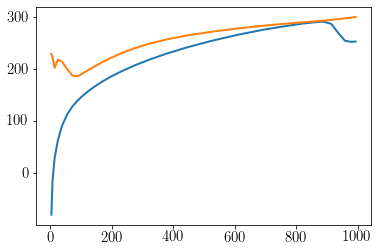

In [28]:
plt.plot(data.lev,np.mean(Tad[:,:,29:35,:],axis=(0,2,3)))
plt.plot(data.lev,np.mean(T[:,:,29:35,:],axis=(0,2,3)))

tgb - 11/13/2019 - This calculation is taking too long because it's an iterative solving algorithm with high precision. Below, I use an extremly cheap and approximate algorithm that calculates the "average moist adiabatic lapse rate" [https://github.com/tbeucler/2016_Moisture_Radiative-Cooling_Instability/blob/master/Gamma_m.m]

In [50]:
# Constants
Gamma_d = g/cp
pref = 625e2
eps = R/Rv
# Range of test moist adiabatic lapse rates
Gm_range = np.linspace(Gamma_d/10,Gamma_d,1000)
Gm = np.zeros(np.shape(data.TS))
# SST range
Ts_range = np.linspace(270,310,4000)

# # For each location, find "best" average lapse rate
# for it in range(data.TS.shape[0]):
#     for ilat in range(data.TS.shape[1]):
#         for ilon in range(data.TS.shape[2]):
Gm = np.zeros((np.size(Ts_range,)))
for iTs,Ts in enumerate(Ts_range):
            
            #Ttest = (data.TS[it,ilat,ilon]).values*(pref/data.PS[it,ilat,ilon]).values**(Gm_range*R/g)
            #Ttest = (data.TS[it,ilat,ilon]).values*(pref/1e5)**(Gm_range*R/g)
    Ttest = Ts*(pref/1e5)**(Gm_range*R/g)
    qsat0 = qsat(Ttest,pref)

    term_0 = Gm_range/Gamma_d
    term_1 = 1+Lc*qsat0/(R*Ttest)
    term_2 = 1+(eps*qsat0*Lc**2)/(cp*R*Ttest**2)

    ind_min = np.argmin(np.abs(term_1/term_2-term_0))
    #print(ind_min)
    #Gm[it,ilat,ilon] = Gm_range[ind_min]
    Gm[iTs] = Gm_range[ind_min]
Ts_MA = np.tile(Ts_range,(30,1))*np.transpose(np.tile(100*data.lev.values/1e5,(4000,1)))**(np.tile(Gm,(30,1))*R/g)

Text(0, 0.5, 'Moist to dry lapse rate ratio')

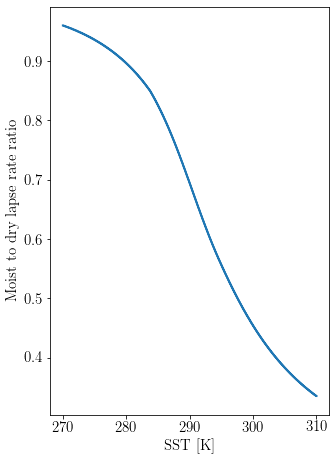

In [26]:
plt.figure(figsize=(5,7.5))
plt.plot(Ts_range,Gm/Gamma_d)
plt.xlabel('SST [K]')
plt.ylabel('Moist to dry lapse rate ratio')

In [51]:
T_MAfit = np.zeros((30,data.TS.values.flatten().size))
for iTs,Ts in enumerate(data.TS.values.flatten()):
    T_MAfit[:,iTs] = Ts_MA[:,np.abs(Ts-Ts_range).argmin()]

In [52]:
T_MAfit_reshape = np.moveaxis(np.reshape(T_MAfit,(30,48,64,128)),0,1)

Text(0, 0.5, 'Pressure [hPa]')

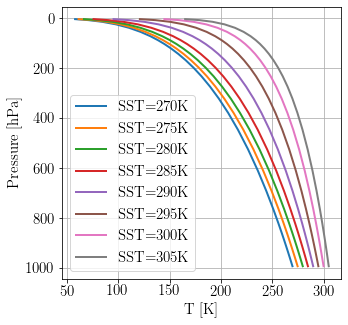

In [53]:
plt.figure(figsize=(5,5))
for i,its in enumerate(np.arange(0,4000)[0:4000:500]):
    plt.plot(Ts_MA[:,its],data.lev,label='SST='+'%02.0f'%Ts_range[its]+'K')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.xlabel('T [K]')
plt.ylabel('Pressure [hPa]')

Text(0, 0.5, 'Pressure [hPa]')

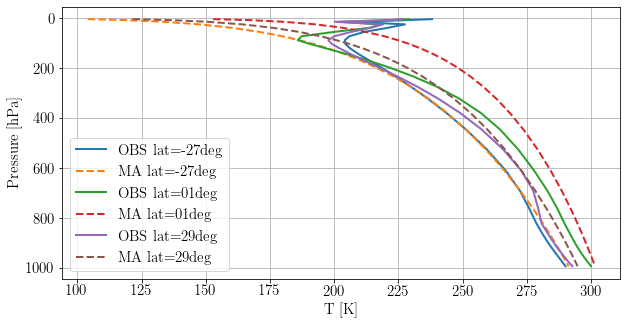

In [54]:
plt.figure(figsize=(10,5))
for i,ilat in enumerate(np.arange(22,52)[0:30:10]):
    plt.plot(np.mean(T[:,:,ilat-2:ilat+2,:],axis=(0,2,3)),data.lev,label='OBS lat='+'%02.0f'%data.lat[ilat]+'deg')
    plt.plot(np.mean(T_MAfit_reshape[:,:,ilat-2:ilat+2,:],axis=(0,2,3)),data.lev,label='MA lat='+'%02.0f'%data.lat[ilat]+'deg',linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.xlabel('T [K]')
plt.ylabel('Pressure [hPa]')

In [56]:
# Save Ts_range and Ts_MA in pkl file
pathPKL = '/local/Tom.Beucler/SPCAM_PHYS'
hf = open(pathPKL+'20191113_MA.pkl','wb')
ForPOG = {"Ts_range" : Ts_range,
          "Ts_MA" : Ts_MA}
pickle.dump(ForPOG,hf)
hf.close()

In [57]:
pathPKL = '/local/Tom.Beucler/SPCAM_PHYS'
hf = open(pathPKL+'20191113_MA.pkl','rb')
MA = pickle.load(hf)

In [58]:
T_MAfit = np.zeros((data.lev.size,data.TS.values.flatten().size))
for iTs,Ts in enumerate(data.TS.values.flatten()):
    T_MAfit[:,iTs] = MA['Ts_MA'][:,np.abs(Ts-MA['Ts_range']).argmin()]

# 2) Check that RH was properly calculated in pre-processing

In [241]:
data118 = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/118_norm.nc",\
                    decode_times=False)

In [172]:
data113 = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/113_train_shuffle.nc",\
                    decode_times=False)

In [176]:
data113v = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/113_valid.nc",\
                    decode_times=False)

In [244]:
data118['mean'][30:60]

<xarray.DataArray 'mean' (var_names: 30)>
array([-60.914722, -67.81505 , -83.90465 , -65.65895 , -69.45241 , -74.238365,
       -78.50785 , -79.4646  , -78.917534, -77.20207 , -75.96267 , -74.214516,
       -71.85186 , -67.52896 , -63.01017 , -55.616413, -48.532215, -40.26776 ,
       -32.159863, -24.795506, -19.070782, -15.10281 , -12.443734, -10.398844,
        -8.807914,  -7.241551,  -5.70717 ,  -4.219784,  -2.920477,  -1.671828],
      dtype=float32)
Coordinates:
  * var_names  (var_names) object 'TfromTS' 'TfromTS' ... 'TfromTS' 'TfromTS'

In [178]:
data113.vars.shape

(42369024, 128)

In [179]:
data113v.vars.shape

(42369024, 128)

# 3) Generalization plots for POG

## 3.1) Data from +0K and +4K experiments

In [31]:
data0K = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-06-01-00000.nc",\
                    decode_times=False)

In [32]:
data4K = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.0000-06-01-00000.nc",\
                        decode_times=False)

## 3.2) Plots

In [33]:
# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [34]:
SSTmax0K = np.max(np.mean(data0K.TS,axis=(0,2)))
ileft = np.argmin(np.abs(SSTmax0K-np.mean(data4K.TS,axis=(0,2))))
iright = np.argmin(np.abs(SSTmax0K-np.mean(data4K.TS,axis=(0,2))[(ileft.values+1):]))+ileft.values+1

Text(0.5, 1.0, 'SST(ref) max=302.2K intersects with lat(+4K)=-15 and 24 deg')

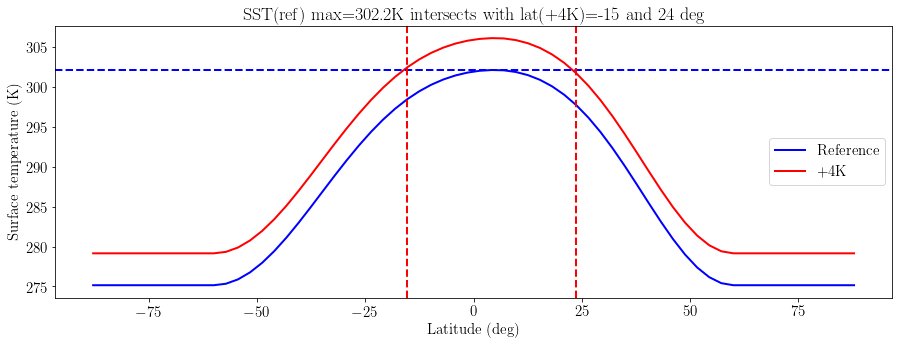

In [63]:
plt.figure(figsize=(15,5))
plt.plot(data0K.lat,np.mean(data0K.TS,axis=(0,2)),label='Reference',color='b')
plt.plot(data4K.lat,np.mean(data4K.TS,axis=(0,2)),label='+4K',color='r')
plt.axhline(y=SSTmax0K,color='b',linestyle='--')
plt.axvline(x=data4K.lat[ileft],color='r',linestyle='--')
plt.axvline(x=data4K.lat[iright],color='r',linestyle='--')
plt.legend()
plt.xlabel('Latitude (deg)')
plt.ylabel('Surface temperature (K)')
plt.title('SST(ref) max='+'%02.1f'%SSTmax0K+'K intersects with lat(+4K)='+
          '%02.0f'%data4K.lat[ileft]+' and '+'%02.0f'%data4K.lat[iright]+' deg')

In [64]:
data0K.QAP[:,-1,:,:].shape

(48, 64, 128)

In [65]:
iright = np.argmin(np.abs(25-1e3*np.mean(data4K.QAP[:,-1,:,:],axis=(0,2)))).values
ileft = np.argmin(np.abs(25-1e3*np.mean(data4K.QAP[:,-1,:iright,:],axis=(0,2))))

In [66]:
print(ileft.values,iright)
print(data0K.lat[ileft].values,data0K.lat[iright].values)

32 36
1.395306910819496 12.557756115230678


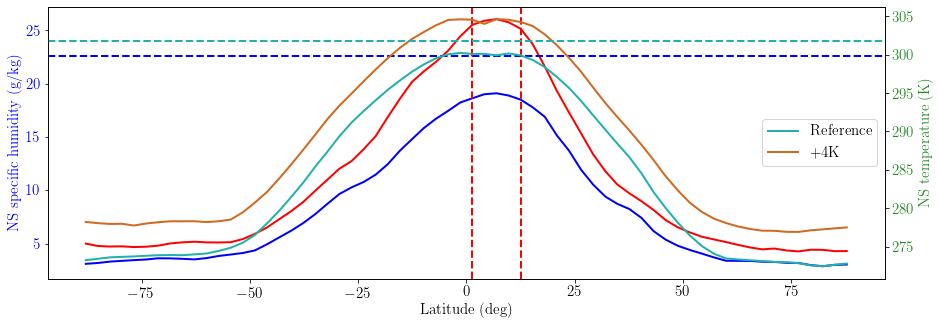

In [67]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('NS specific humidity (g/kg)',color='b')
ax1.plot(data0K.lat,1e3*np.mean(data0K.QAP[:,-1,:,:],axis=(0,2)),color='b')
ax1.plot(data4K.lat,1e3*np.mean(data4K.QAP[:,-1,:,:],axis=(0,2)),color='r')
ax1.axhline(y=np.max(1e3*data0K.QAP[:,-1,:,:]),color='b',linestyle='--')
ax1.axvline(x=data4K.lat[ileft],color='r',linestyle='--')
ax1.axvline(x=data4K.lat[iright],color='r',linestyle='--')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_xlabel('Latitude (deg)')
ax2.set_ylabel('NS temperature (K)',color='forestgreen')
ax2.plot(data0K.lat,np.mean(data0K.TAP[:,-1,:,:],axis=(0,2)),color='lightseagreen',label='Reference')
ax2.plot(data4K.lat,np.mean(data4K.TAP[:,-1,:,:],axis=(0,2)),color='chocolate',label='+4K')
ax2.axhline(y=np.max(data0K.TAP[:,-1,:,:]),color='lightseagreen',linestyle='--')
ax2.tick_params(axis='y', labelcolor='forestgreen')
ax2.legend()

In [68]:
RH0 = RH(data0K.TAP,data0K.QAP,data0K.P0,data0K.PS,data0K.hyam,data0K.hybm)

In [69]:
RH4 = RH(data4K.TAP,data4K.QAP,data4K.P0,data4K.PS,data4K.hyam,data0K.hybm)

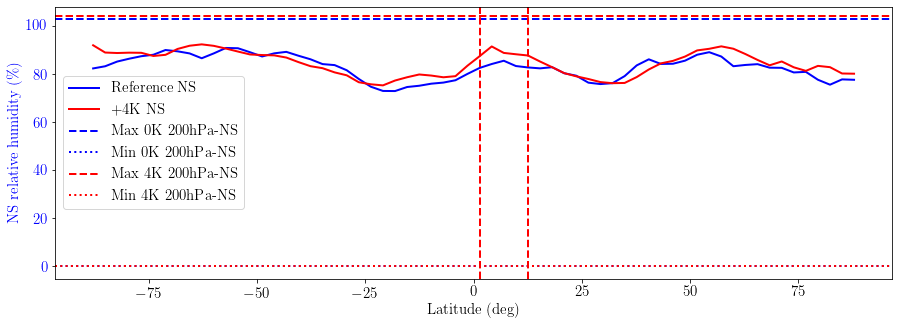

In [102]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('NS relative humidity (\%)',color='b')
ax1.plot(data0K.lat,1e2*np.mean(RH0[:,-1,:,:],axis=(0,2)),color='b',label='Reference NS')
ax1.plot(data4K.lat,1e2*np.mean(RH4[:,-1,:,:],axis=(0,2)),color='r',label='+4K NS')
ax1.axhline(y=np.max(1e2*RH0[:,12:,:,:]),color='b',linestyle='--',label='Max 0K 200hPa-NS')
ax1.axhline(y=np.min(1e2*RH0[:,12:,:,:]),color='b',linestyle=':',label='Min 0K 200hPa-NS')
ax1.axhline(y=np.max(1e2*RH4[:,12:,:,:]),color='r',linestyle='--',label='Max 4K 200hPa-NS')
ax1.axhline(y=np.min(1e2*RH4[:,12:,:,:]),color='r',linestyle=':',label='Min 4K 200hPa-NS')
ax1.axvline(x=data4K.lat[ileft],color='r',linestyle='--')
ax1.axvline(x=data4K.lat[iright],color='r',linestyle='--')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend()

In [71]:
T_MAfit = np.zeros((data0K.lev.size,data0K.TS.values.flatten().size))
for iTs,Ts in enumerate(data0K.TS.values.flatten()):
    T_MAfit[:,iTs] = MA['Ts_MA'][:,np.abs(Ts-MA['Ts_range']).argmin()]
T_MAfit_0K = np.moveaxis(np.reshape(T_MAfit,(30,48,64,128)),0,1)

In [72]:
T_fromMA_0K = data0K.TAP-T_MAfit_0K

In [73]:
T_MAfit = np.zeros((data4K.lev.size,data0K.TS.values.flatten().size))
for iTs,Ts in enumerate(data4K.TS.values.flatten()):
    T_MAfit[:,iTs] = MA['Ts_MA'][:,np.abs(Ts-MA['Ts_range']).argmin()]
T_MAfit_4K = np.moveaxis(np.reshape(T_MAfit,(30,48,64,128)),0,1)
T_fromMA_4K = data0K.TAP-T_MAfit_4K

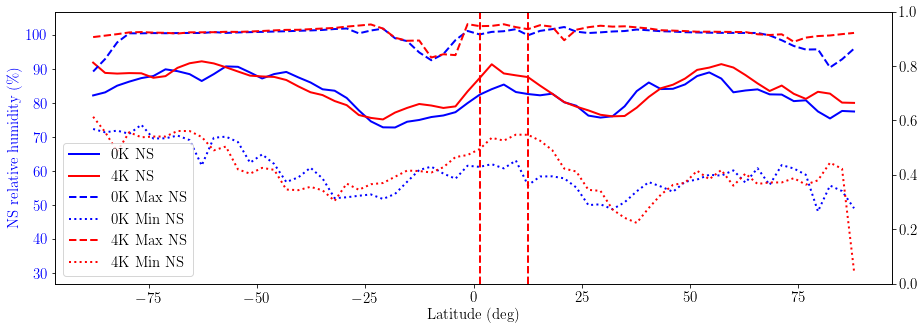

In [117]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('NS relative humidity (\%)',color='b')
ax1.plot(data0K.lat,1e2*np.mean(RH0[:,-1,:,:],axis=(0,2)),color='b',label='0K NS')
ax1.plot(data4K.lat,1e2*np.mean(RH4[:,-1,:,:],axis=(0,2)),color='r',label='4K NS')
ax1.plot(data0K.lat,np.max(1e2*RH0[:,-1,:,:],axis=(0,2)),color='b',linestyle='--',label='0K Max NS')
ax1.plot(data0K.lat,np.min(1e2*RH0[:,-1,:,:],axis=(0,2)),color='b',linestyle=':',label='0K Min NS')
ax1.plot(data4K.lat,np.max(1e2*RH4[:,-1,:,:],axis=(0,2)),color='r',linestyle='--',label='4K Max NS')
ax1.plot(data4K.lat,np.min(1e2*RH4[:,-1,:,:],axis=(0,2)),color='r',linestyle=':',label='4K Min NS')
ax1.axvline(x=data4K.lat[ileft],color='r',linestyle='--')
ax1.axvline(x=data4K.lat[iright],color='r',linestyle='--')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_xlabel('Latitude (deg)')
# ax2.set_ylabel('NS temp. from MA (K)',color='forestgreen')
# ax2.plot(data0K.lat,np.mean(T_fromMA_0K[:,-1,:,:],axis=(0,2)),color='lightseagreen',label='Reference NS')
# ax2.plot(data4K.lat,np.mean(T_fromMA_4K[:,-1,:,:],axis=(0,2)),color='chocolate',label='+4K NS')
# ax2.plot(data0K.lat,np.max(T_fromMA_0K[:,12:,:,:],axis=(0,1,3)),color='lightseagreen',linestyle='--',label='0K Max 200hPa-NA')
# ax2.plot(data0K.lat,np.min(T_fromMA_0K[:,12:,:,:],axis=(0,1,3)),color='lightseagreen',linestyle=':',label='0K Min 200hPa-NA')
# ax2.plot(data4K.lat,np.max(T_fromMA_4K[:,12:,:,:],axis=(0,1,3)),color='chocolate',linestyle='--',label='4K Max 200hPa-NA')
# ax2.plot(data4K.lat,np.min(T_fromMA_4K[:,12:,:,:],axis=(0,1,3)),color='chocolate',linestyle=':',label='4K Min 200hPa-NA')
# ax2.tick_params(axis='y', labelcolor='forestgreen')
# ax2.legend()

In [248]:
# TfromTS_0K = data0K.TAP - data0K.TS
# TfromTS_4K = data4K.TAP - data4K.TS
Tmax = np.max(data0K.TAP,axis=1)
Tmin = np.min(data0K.TAP,axis=1)
TfromTS_0K = -(data0K.TAP - Tmax)/(Tmax-Tmin)
Tmax = np.max(data4K.TAP,axis=1)
Tmin = np.min(data4K.TAP,axis=1)
TfromTS_4K = -(data4K.TAP - Tmax)/(Tmax-Tmin)

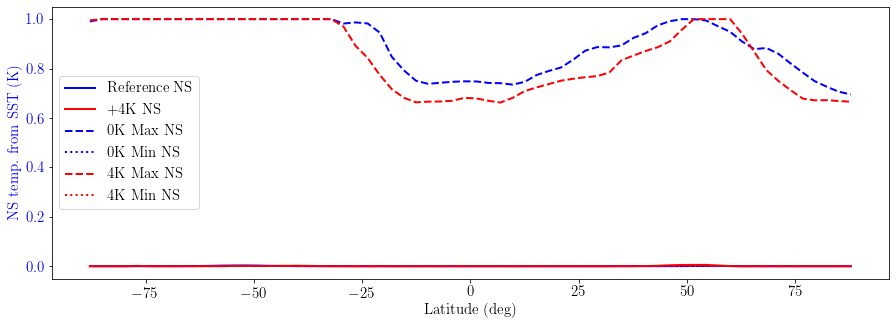

In [249]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('NS temp. from SST (K)',color='b')
ax1.plot(data0K.lat,np.mean(TfromTS_0K[:,-1,:,:],axis=(0,2)),color='b',label='Reference NS')
ax1.plot(data4K.lat,np.mean(TfromTS_4K[:,-1,:,:],axis=(0,2)),color='r',label='+4K NS')
ax1.plot(data0K.lat,np.max(TfromTS_0K[:,12:,:,:],axis=(0,1,3)),color='b',linestyle='--',label='0K Max NS')
ax1.plot(data0K.lat,np.min(TfromTS_0K[:,12:,:,:],axis=(0,1,3)),color='b',linestyle=':',label='0K Min NS')
ax1.plot(data4K.lat,np.max(TfromTS_4K[:,12:,:,:],axis=(0,1,3)),color='r',linestyle='--',label='4K Max NS')
ax1.plot(data4K.lat,np.min(TfromTS_4K[:,12:,:,:],axis=(0,1,3)),color='r',linestyle=':',label='4K Min NS')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend()

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_xlabel('Latitude (deg)')
# ax2.set_ylabel('NS temp. from MA (K)',color='forestgreen')
# ax2.plot(data0K.lat,np.mean(T_fromMA_0K[:,-1,:,:],axis=(0,2)),color='lightseagreen',label='Reference')
# ax2.plot(data4K.lat,np.mean(T_fromMA_4K[:,-1,:,:],axis=(0,2)),color='chocolate',label='+4K')
# # ax2.axhline(y=np.max(T_fromMA_0K[:,-1,:,:]),color='lightseagreen',linestyle='--')
# # ax2.axhline(y=np.min(T_fromMA_0K[:,-1,:,:]),color='lightseagreen',linestyle='--')
# ax2.tick_params(axis='y', labelcolor='forestgreen')
# ax2.legend()

In [219]:
# First plot tropopause height as function of latitude
# 0K
Ttpp0K = np.mean(np.min(data0K.TAP,axis=1),axis=(0,2))
Ttpp0Kmax = np.max(np.min(data0K.TAP,axis=1),axis=(0,2))
Ttpp0Kmin = np.min(np.min(data0K.TAP,axis=1),axis=(0,2))
ptpp0K = np.mean(data0K.lev[np.argmin(data0K.TAP,axis=1)],axis=(0,2))
ptpp0Kmax = np.max(data0K.lev[np.argmin(data0K.TAP,axis=1)],axis=(0,2))
ptpp0Kmin = np.min(data0K.lev[np.argmin(data0K.TAP,axis=1)],axis=(0,2))
# 4K
Ttpp4K = np.mean(np.min(data4K.TAP,axis=1),axis=(0,2))
Ttpp4Kmax = np.max(np.min(data4K.TAP,axis=1),axis=(0,2))
Ttpp4Kmin = np.min(np.min(data4K.TAP,axis=1),axis=(0,2))
ptpp4K = np.mean(data4K.lev[np.argmin(data4K.TAP,axis=1)],axis=(0,2))
ptpp4Kmax = np.max(data4K.lev[np.argmin(data4K.TAP,axis=1)],axis=(0,2))
ptpp4Kmin = np.min(data4K.lev[np.argmin(data4K.TAP,axis=1)],axis=(0,2))

In [222]:
#fig, ax1 = plt.subplots(figsize=(15,10))

# ax1.set_xlabel('Latitude (deg)')
# ax1.set_ylabel('Mean tropopause pressure (hPa)',color='b')
# ax1.plot(data0K.lat,ptpp0K,color='b',label='p Reference')
# ax1.plot(data0K.lat,ptpp0Kmax,color='b',linestyle='--')
# ax1.plot(data0K.lat,ptpp0Kmin,color='b',linestyle=':')
# ax1.plot(data4K.lat,ptpp4K,color='r',label='p +4K')
# ax1.plot(data4K.lat,ptpp4Kmax,color='r',linestyle='--')
# ax1.plot(data4K.lat,ptpp4Kmin,color='r',linestyle=':')
# ax1.legend(loc='upper right')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_ylabel('Mean tropopause temperature (K)',color='deepskyblue')
# ax2.plot(data0K.lat,Ttpp0K,color='deepskyblue',label='T reference')
# ax2.plot(data0K.lat,Ttpp0Kmax,color='deepskyblue',linestyle='--')
# ax2.plot(data0K.lat,Ttpp0Kmin,color='deepskyblue',linestyle=':')
# ax2.plot(data4K.lat,Ttpp4K,color='salmon',label='T +4K')
# ax2.plot(data0K.lat,Ttpp4Kmax,color='salmon',linestyle='--')
# ax2.plot(data0K.lat,Ttpp4Kmin,color='salmon',linestyle=':')
# ax2.legend(loc='right')

Is network less invariant in `qtilde = q*/q*_Surface`?

In [223]:
p0 = np.moveaxis((data0K.hyam*data0K.P0+data0K.hybm*data0K.PS).values,0,1) # Total pressure (Pa)

In [226]:
qtilde = qsat(data0K.TAP,p0)/qsat(data0K.TS,data0K.PS)
qtilde = 

(0, 2)

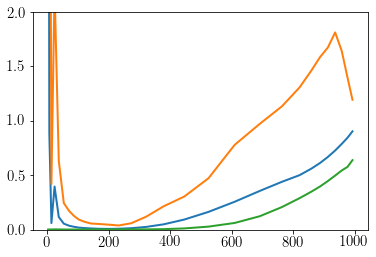

In [239]:
plt.plot(data0K.lev,np.mean(qtilde,axis=(0,2,3)))
plt.plot(data0K.lev,np.max(qtilde,axis=(0,2,3)))
plt.plot(data0K.lev,np.min(qtilde,axis=(0,2,3)))
plt.ylim((0,2))

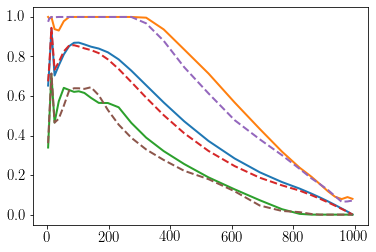

In [250]:
plt.plot(data0K.lev,np.mean(TfromTS_0K,axis=(0,2,3)))
plt.plot(data0K.lev,np.max(TfromTS_0K,axis=(0,2,3)))
plt.plot(data0K.lev,np.min(TfromTS_0K,axis=(0,2,3)))
plt.plot(data4K.lev,np.mean(TfromTS_4K,axis=(0,2,3)),linestyle='--')
plt.plot(data4K.lev,np.max(TfromTS_4K,axis=(0,2,3)),linestyle='--')
plt.plot(data4K.lev,np.min(TfromTS_4K,axis=(0,2,3)),linestyle='--')